# Instrength and intrinsic frequency gradient mechanisms interact in a 2D network model

In [1]:
import yaml
import numpy as np
import matplotlib.pylab as plt

from scipy import spatial
from scipy.stats import spearmanr, multivariate_normal

from tvb.simulator.lab import *

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

from palettable.cmocean.sequential import Ice_20
from palettable.scientific.sequential import Davos_20, LaPaz_20, Turku_20
import cmasher as cmr

cmap_potential = cmr.eclipse
cmap_waves = Ice_20.mpl_colormap
cmap_fq = LaPaz_20.mpl_colormap
cmap_strength = Davos_20.mpl_colormap
cmap_weights = Turku_20.mpl_colormap

from modules.helpers import *
from modules.visualization import *
from modules.wave_detection_methods import *

dpi = 300
plt.rcParams.update({'font.size': 8})

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# Define functions
def exp_kernel(distance, sigma):
    """ Exponential kernel function for distance-dependent connection strength"""
    f = 1/(2*sigma) * np.exp(-distance/sigma)        
    return f

In [25]:
# Read Configuration
try:
    configuration_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/configuration/03_configuration.yaml"
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise

try:
    configuration_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/configuration/03_analysis_configuration.yaml"
    with open(configuration_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise

    
# Simulation Parameters
# ---------------------
experiment_id = config["experiment_id"]
save_path = config["save_path"]
save_path_analysis = config_analysis["save_path_analysis"]
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"

number_of_simulations = 100

integration_step_size = float(config["integration_step_size"])  # ms
simulation_duration = float(config["simulation_duration"])  # ms
initial_transient = float(config["initial_transient"])  # ms
initial_transient_samples = int(initial_transient/integration_step_size)  # samples
number_of_timesteps = int((simulation_duration-initial_transient)/integration_step_size)

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int((simulation_duration-initial_transient)/integration_step_size_downsampled)


# Model Parameters
# ----------------
intrinsic_frequency_mean = float(config["intrinsic_frequency_mean"])  # Hz - Kuramoto oscillator intrinsic frequency mean

coupling_strength = np.array(float(config["coupling_strength"]))  # global scaling of all connections
conduction_speed = float(config["conduction_speed"])  # mm/ms
connection_strength_scaling = float(config["connection_strength_scaling"])  # scaling factor for distance-dependent connection strength
connection_probability_scale = float(config["connection_probability_scale"])  # scale parameter for distance-dependent connection probability

instrength_gradient_offset = float(config["instrength_gradient_offset"])
instrength_gradient_scaling = float(config['instrength_gradient_scaling'])
sink_pos = np.array(config["sink_pos"])
source_pos = np.array(config["source_pos"])
singularity_width = float(config["singularity_width"])

# network parameters
nx = int(config["nx"])  # number of regions along x-dimension
ny = int(config["ny"])  # number of regions along y-dimension

N = nx*ny  # number of regions

x_extent = float(config["x_extent"])  # mm, extent of x-dimension
y_extent = float(config["y_extent"])  # mm, extent of y-dimension

# create node positions
y = np.linspace(0, y_extent, ny)
x = np.linspace(0, x_extent, nx)
pos = np.zeros((N,2))
pos[:,:] = np.array(np.meshgrid(x, y)).T.reshape(-1,2)

# prepare mesh
v = np.c_[pos, np.zeros(len(pos))]
f = spatial.Delaunay(pos).simplices


# Analysis Parameters
# -------------------
significance_level = float(config_analysis["significance_level"])

gradient_scaling_start, gradient_scaling_end, gradient_scaling_steps = np.array(config["intrinsic_frequency_gradient_scaling"], dtype=float)
gradient_scaling = np.linspace(gradient_scaling_start, gradient_scaling_end, int(gradient_scaling_steps))

In [5]:
# Create Network
# --------------
sc = connectivity.Connectivity()
sc.centres = pos


# Create distance-dependent connectivity
distance_matrix = spatial.distance.cdist(pos, pos)
np.fill_diagonal(distance_matrix, np.inf)  # avoids self-connections

# distance-dependent connection strength
A = exp_kernel(distance_matrix, connection_strength_scaling)

# calculate distance-dependent connection probability mask
connection_mask = distance_matrix <= abs(np.random.exponential(scale=connection_probability_scale, size=(N,N)))

A[connection_mask==0] = 0
A /= A.sum(axis=0)  # normalize connections


# create spatial in-strength gradient
sink = multivariate_normal(sink_pos, cov=singularity_width).pdf(pos)  # generate sink gaussian
source = multivariate_normal(source_pos, cov=singularity_width).pdf(pos)  # generate source gaussian

gradient = (sink - source)  # combine and gaussians to create gradient
gradient = (gradient - gradient.min()) * 2 / (gradient.max() - gradient.min()) - 1  # min-max normalized gradient
instrength_gradient_field = instrength_gradient_scaling * gradient + instrength_gradient_offset

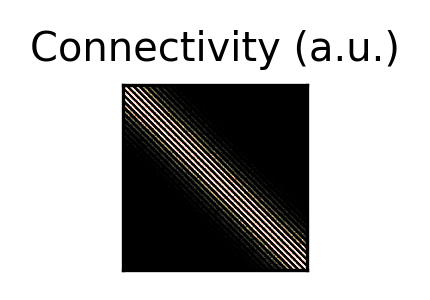

In [6]:
# Plot weights
fig, ax = plt.subplots(1, figsize=(0.8, 0.8), dpi=300)

weights_threshold = np.percentile(A[A!=0].flatten(), 50)  # clip weights at 90th percentile

im = ax.imshow(A, cmap=cmap_weights, aspect=1)
ax.set_title('Connectivity (a.u.)')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([])

im.set_clim([0, weights_threshold])


#plt.savefig(os.path.join(data_path, '03_results/03_2d_connectivity.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(data_path, '03_results/03_2d_connectivity.svg'), dpi=300, transparent=False, bbox_inches='tight')

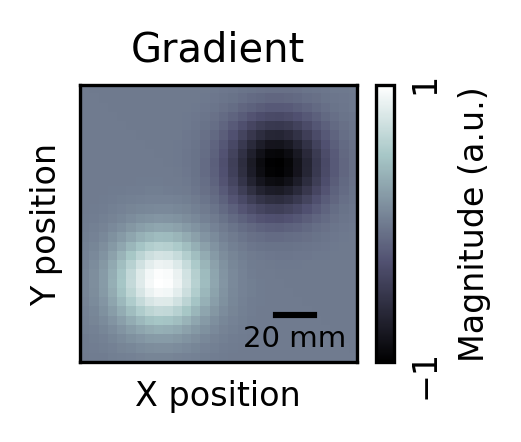

In [8]:
# Plot template gradient
fontprops = fm.FontProperties(size=7)

fig, ax = plt.subplots(1, figsize=(1.2, 1.2), dpi=300)

scalebar = AnchoredSizeBar(ax.transData,
                           20, '20 mm', 
                           'lower right', 
                           color='black',
                           borderpad=0.25,
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

im = ax.imshow(gradient.reshape(nx,ny).T, origin='lower', cmap='bone', aspect=1, extent=[0, 140, 0, 140])
ax.set_title('Gradient')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('X position')
ax.set_ylabel('Y position')

cbar_ax = fig.add_axes([.95, 0.11, 0.05, 0.77])

cbar = fig.colorbar(im, ax=ax, cax=cbar_ax, pad=0.02, orientation='vertical')
cbar.set_label('Magnitude (a.u.)')
cbar.set_ticks(ticks=[-1, 1])
#cbar.ax.set_yticklabels(['low', 'high'], va='center')
cbar.ax.tick_params(size=0, rotation=90)

#plt.savefig(os.path.join(data_path, '03_results/03_gradient.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(data_path, '03_results/03_gradient.svg'), dpi=300, transparent=False, bbox_inches='tight')

[]

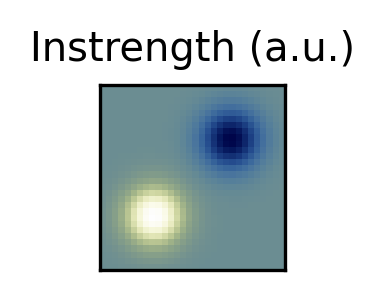

In [9]:
# Plot instrength gradient
fig, ax = plt.subplots(1, figsize=(0.8, 0.8), dpi=300)

im = ax.imshow(gradient.reshape(nx,ny).T, origin='lower', cmap=cmap_strength, aspect=1, extent=[0, 140, 0, 140])
ax.set_title('Instrength (a.u.)')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([])

#plt.savefig(os.path.join(data_path, '03_results/03_instrength_gradient.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(data_path, '03_results/03_instrength_gradient.svg'), dpi=300, transparent=False, bbox_inches='tight')

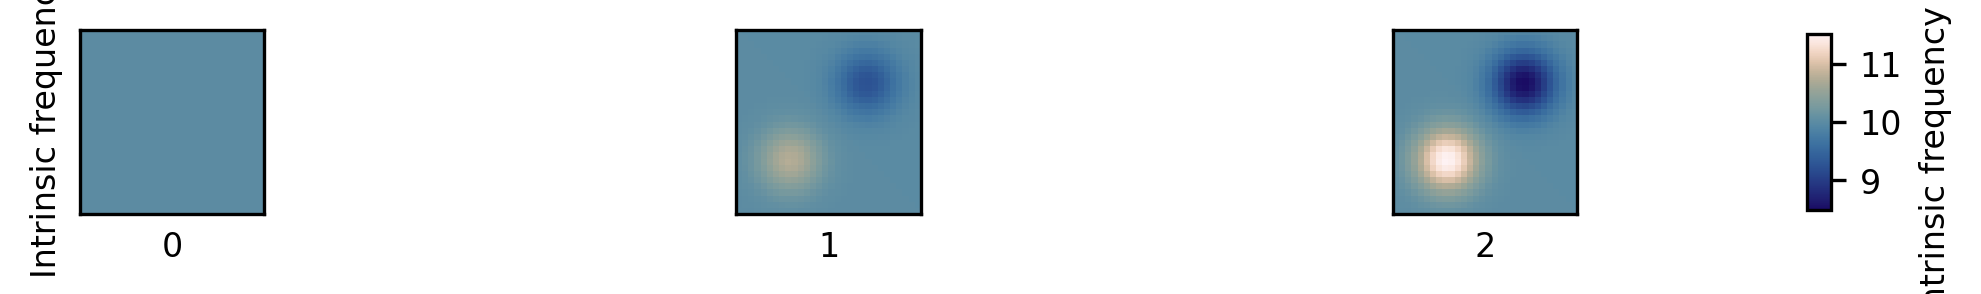

In [15]:
# Intrinsic frequency examples
number_of_images = 3
images = np.zeros((nx, ny, number_of_images))
images[:,:,0] = intrinsic_frequency_mean + gradient_scaling[0] * gradient.reshape(nx,ny).T
images[:,:,1] = intrinsic_frequency_mean + gradient_scaling[15] * gradient.reshape(nx,ny).T
images[:,:,2] = intrinsic_frequency_mean + gradient_scaling[30] * gradient.reshape(nx,ny).T
vmin = images.min()
vmax = images.max()
samples = range(number_of_images)
xlabels = [f"{s - np.min(samples)}" for s in samples] 

plot_imshow_timeseries(images, samples, xlabels, 'Intrinsic frequency', r'Intrinsic frequency (Hz)',
                       vmin=vmin,
                       vmax=vmax,
                       cbticks=None, 
                       cbticklabels=None,
                       cmap=cmap_fq,
                       figsize=(8,0.8),
                       position=[0.92, 0.13, 0.01, 0.73]
                      )

#plt.savefig(os.path.join(data_path, '03_results/03_intrinsic_frequency_gradient.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(data_path, '03_results/03_intrinsic_frequency_gradient.svg'), dpi=300, transparent=False, bbox_inches='tight')

### Analyses

In [20]:
### Load aggregated data ###
# gradient - potential correlation
gradient_potential_corr = np.load(os.path.join(data_path, f"{save_path_analysis}_aggregated", f"{experiment_id}_gradient_potential_corr_div.npy"))
gradient_potential_corr_median = np.median(gradient_potential_corr, axis=0)
gradient_potential_corr_iqr = np.percentile(gradient_potential_corr, [25, 75], axis=0)

# gradient - effective frequency 
gradient_effective_frequency_corr = np.load(os.path.join(data_path, f"{save_path_analysis}_aggregated", f"{experiment_id}_gradient_effective_frequency_corr_div.npy"))
gradient_effective_frequency_corr_median = np.median(gradient_effective_frequency_corr, axis=0)
gradient_effective_frequency_corr_iqr = np.percentile(gradient_effective_frequency_corr, [25, 75], axis=0)

# proportion of waves
proportion_waves = np.load(os.path.join(data_path, f"{save_path_analysis}_aggregated", f"{experiment_id}_proportion_div_waves.npy"))
proportion_waves_median = np.median(proportion_waves, axis=0) * 100
proportion_waves_iqr = np.percentile(proportion_waves, [25, 75], axis=0) * 100

non_guided_idx = np.argmin(abs(gradient_potential_corr_median))  # get index where gradients are roughly balanced

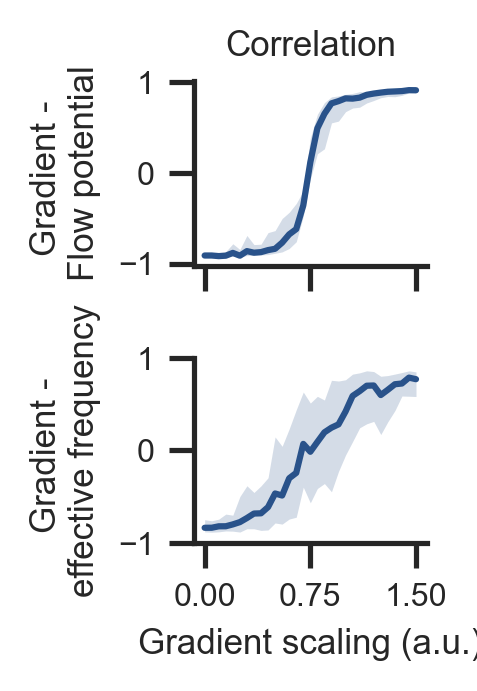

In [18]:
# Plot gradient scaling vs. flow potential and EF 
sns.set(style="ticks", font_scale=0.7)
fig, ax = plt.subplots(2, 1, figsize=(1., 1.*2), sharex=True, dpi=300)

ax[0].plot(gradient_scaling, gradient_potential_corr_median, color='#29528a')
ax[0].fill_between(gradient_scaling, gradient_potential_corr_iqr[0], gradient_potential_corr_iqr[1], alpha=0.2, color='#29528a', lw=0)
ax[0].set_title('Correlation')
ax[0].yaxis.set_ticks([-1.0, 0., 1.])
ax[0].set_ylabel('Gradient - \nFlow potential')

ax[1].plot(gradient_scaling, gradient_effective_frequency_corr_median, color='#29528a')
ax[1].fill_between(gradient_scaling, gradient_effective_frequency_corr_iqr[0], gradient_effective_frequency_corr_iqr[1], alpha=0.2, color='#29528a', lw=0)
ax[1].yaxis.set_ticks([-1.0, 0., 1.])
ax[1].set_ylabel('Gradient - \neffective frequency')
ax[1].set_xlabel('Gradient scaling (a.u.)')
ax[1].xaxis.set_ticks([.0, 0.75, 1.5])

sns.despine()
plt.subplots_adjust(hspace=0.5)

#plt.savefig(os.path.join(data_path, '03_results/03_instrength_intrinsic-frequency_gradients.png'), dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig(os.path.join(data_path, '03_results/03_instrength_intrinsic-frequency_gradients.svg'), dpi=300, transparent=True, bbox_inches='tight')

In [21]:
# Average flow potentials for instrength-directed, intrisic-frequency-directed, and non-directed waves
instrength_guided_potential = []
intrinsic_frequency_guided_potential = []
non_guided_potential = []
for sim_id in range(number_of_simulations):
    instrength_guided_potential.append(np.mean(np.load(os.path.join(data_path, f"03_analysis", f"{experiment_id}_potential_div_{sim_id}_{0}.npy")), axis=1))
    intrinsic_frequency_guided_potential.append(np.mean(np.load(os.path.join(data_path, f"03_analysis", f"{experiment_id}_potential_div_{sim_id}_{30}.npy")), axis=1))
    non_guided_potential.append(np.mean(np.load(os.path.join(data_path, f"03_analysis", f"{experiment_id}_potential_div_{sim_id}_{non_guided_idx}.npy")), axis=1))
    
instrength_guided_potential_avg = np.mean(instrength_guided_potential, axis=0)
intrinsic_frequency_guided_potential_avg = np.mean(intrinsic_frequency_guided_potential, axis=0)
non_guided_potential_avg = np.mean(non_guided_potential, axis=0)

Text(-0.2, 0.5, 'Gradient scaling (a.u.)')

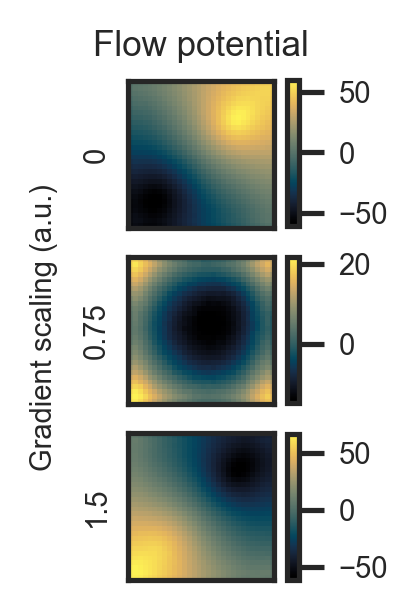

In [23]:
# Plot average flow potentials
fig, ax = plt.subplots(3, 1, figsize=(.8, .8*2.7), dpi=300)

im = ax[0].imshow(instrength_guided_potential_avg.reshape(nx,ny).T, origin='lower', cmap=cmap_potential, aspect=1, extent=[0, 140, 0, 140])
ax[0].set_title('Flow potential')
ax[0].set_ylabel('0', fontsize=7)
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[0].set_yticks([])
ax[0].set_xticks([])
cbar_ax = plt.gcf().add_axes([.87, 0.656, 0.05, 0.225])  # [left, bottom, width, height]
cbar = fig.colorbar(im, ax=ax[2], cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=7) 

im = ax[1].imshow(non_guided_potential_avg.reshape(nx,ny).T, origin='lower', cmap=cmap_potential, aspect=1, extent=[0, 140, 0, 140])
ax[1].set_ylabel('0.75', fontsize=7)
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_yticks([])
ax[1].set_xticks([])
cbar_ax = plt.gcf().add_axes([.87, 0.383, 0.05, 0.225])  # [left, bottom, width, height]
cbar = fig.colorbar(im, ax=ax[2], cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=7) 

im = ax[2].imshow(intrinsic_frequency_guided_potential_avg.reshape(nx,ny).T, origin='lower', cmap=cmap_potential, aspect=1, extent=[0, 140, 0, 140])
ax[2].set_ylabel('1.5', fontsize=7)
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])
ax[2].set_yticks([])
ax[2].set_xticks([])
cbar_ax = plt.gcf().add_axes([.87, 0.11, 0.05, 0.225])  # [left, bottom, width, height]
cbar = fig.colorbar(im, ax=ax[2], cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=7) 

fig.supylabel('Gradient scaling (a.u.)', fontsize=7, x=-0.2)

#plt.savefig(os.path.join(data_path, '03_results/03_potentials.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(data_path, '03_results/03_potentials.svg'), dpi=300, transparent=False, bbox_inches='tight')

In [28]:
# Average effective frequency for instrength-directed, intrisic-frequency-directed, and non-directed waves
instrength_guided_ef = []
intrinsic_frequency_guided_ef = []
non_guided_ef = []
for sim_id in range(number_of_simulations):
    instrength_guided_ef.append(np.median(np.load(os.path.join(data_path, f"{save_path_analysis}", f"{experiment_id}_effective_frequency_{sim_id}_{0}.npy")), axis=1))
    intrinsic_frequency_guided_ef.append(np.median(np.load(os.path.join(data_path, f"{save_path_analysis}", f"{experiment_id}_effective_frequency_{sim_id}_{30}.npy")), axis=1))
    non_guided_ef.append(np.median(np.load(os.path.join(data_path, f"{save_path_analysis}", f"{experiment_id}_effective_frequency_{sim_id}_{non_guided_idx}.npy")), axis=1))
    
instrength_guided_ef_avg = np.mean(instrength_guided_ef, axis=0)
intrinsic_frequency_guided_ef_avg = np.mean(intrinsic_frequency_guided_ef, axis=0)
non_guided_ef_avg = np.mean(non_guided_ef, axis=0)

Text(-0.2, 0.5, '')

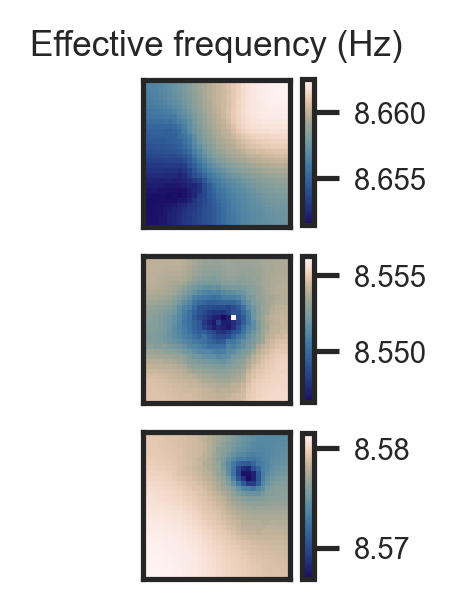

In [29]:
# Plot average effective frequency
fontprops = fm.FontProperties(size=7)

fig, ax = plt.subplots(3, 1, figsize=(.8, .8*2.7), dpi=300)

im = ax[0].imshow(instrength_guided_ef_avg.reshape(nx,ny).T, origin='lower', cmap=cmap_fq, aspect=1, extent=[0, 140, 0, 140])
ax[0].set_title('Effective frequency (Hz)')
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[0].set_yticks([])
ax[0].set_xticks([])
cbar_ax = plt.gcf().add_axes([.87, 0.656, 0.05, 0.225])  # [left, bottom, width, height]
cbar = fig.colorbar(im, ax=ax[2], cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=7)

im = ax[1].imshow(non_guided_ef_avg.reshape(nx,ny).T, origin='lower', cmap=cmap_fq, aspect=1, extent=[0, 140, 0, 140])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_yticks([])
ax[1].set_xticks([])
cbar_ax = plt.gcf().add_axes([.87, 0.383, 0.05, 0.225])  # [left, bottom, width, height]
cbar = fig.colorbar(im, ax=ax[2], cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=7)

im = ax[2].imshow(intrinsic_frequency_guided_ef_avg.reshape(nx,ny).T, origin='lower', cmap=cmap_fq, aspect=1, extent=[0, 140, 0, 140])
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])
ax[2].set_yticks([])
ax[2].set_xticks([])
cbar_ax = plt.gcf().add_axes([.87, 0.11, 0.05, 0.225])  # [left, bottom, width, height]
cbar = fig.colorbar(im, ax=ax[2], cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=7) 

fig.supylabel('', fontsize=7, x=-0.2)

#plt.savefig(os.path.join(data_path, '03_results/03_effective_frequency.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(data_path, '03_results/03_effective_frequency.svg'), dpi=300, transparent=False, bbox_inches='tight')

### Instrength-directed waves - example timeseries

In [30]:
# load data
simulation_id = 0
gradient_scaling_id = 0

phase = np.load(os.path.join(data_path, f"{experiment_id}_simulations/{experiment_id}_simulation_{simulation_id}_{gradient_scaling_id}.npy"))
phase = phase[initial_transient_samples:].copy()

# map phase to 2D
phase_2d = np.mod(phase.reshape(number_of_timesteps, nx, ny).transpose((2,1,0)), np.pi*2)

activity = np.real(np.exp(1j*phase_2d))

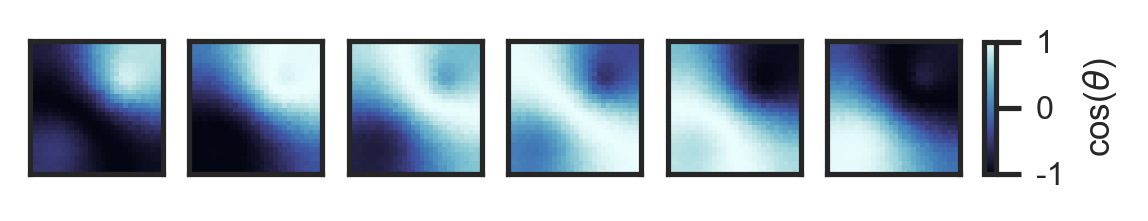

In [31]:
# wave example plots
number_of_images = 6
time_start = 8340  # ms
time_end = 8420  # ms
samples = (np.linspace(time_start, time_end, number_of_images)/integration_step_size).astype(int)
#xlabels = [f"{s - np.min(samples)} ms" for s in samples] 
xlabels = [f"" for s in samples] 

plot_imshow_timeseries(activity, samples, xlabels, '', r'cos($\theta$)',
                       vmin=-1,
                       vmax=1,
                       cbticks=[-1, 0, 1], 
                       cbticklabels=['-1', '0', '1'],
                       cmap=cmap_waves,
                       figsize=(4,0.8),
                       position=[0.92, 0.22, 0.01, 0.55]
                      )

#plt.savefig(os.path.join(data_path, '03_results/03_example_wave_instrength-guided.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(data_path, '03_results/03_example_wave_instrength-guided.svg'), dpi=300, transparent=False, bbox_inches='tight')

### Non-directed waves - example timeseries

In [40]:
# load data
simulation_id = 1
gradient_scaling_id = non_guided_idx

phase = np.load(os.path.join(data_path, f"{experiment_id}_simulations/{experiment_id}_simulation_{simulation_id}_{gradient_scaling_id}.npy"))
phase = phase[initial_transient_samples:].copy()

# map phase to 2D
phase_2d = np.mod(phase.reshape(number_of_timesteps, nx, ny).transpose((2,1,0)), np.pi*2)

activity = np.real(np.exp(1j*phase_2d))

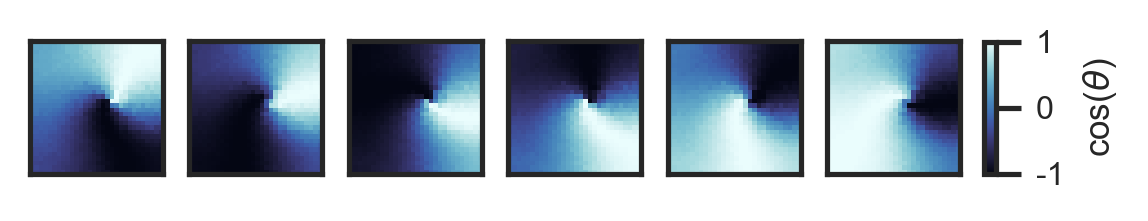

In [41]:
# wave example plots
number_of_images = 6
time_start = 9240  # ms
time_end = 9320  # ms
samples = (np.linspace(time_start, time_end, number_of_images)/integration_step_size).astype(int)
#xlabels = [f"{s - np.min(samples)} ms" for s in samples] 
xlabels = [f"" for s in samples] 

plot_imshow_timeseries(activity, samples, xlabels, '', r'cos($\theta$)',
                       vmin=-1,
                       vmax=1,
                       cbticks=[-1, 0, 1], 
                       cbticklabels=['-1', '0', '1'],
                       cmap=cmap_waves,
                       figsize=(4,0.8),
                       position=[0.92, 0.22, 0.01, 0.55]
                      )

#plt.savefig(os.path.join(data_path, '03_results/03_example_wave_midgradient.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(data_path, '03_results/03_example_wave_midgradient.svg'), dpi=300, transparent=False, bbox_inches='tight')

### Intrinsic-frequency-directed waves - example timeseries

In [44]:
# load data
simulation_id = 0
gradient_scaling_id = 30

phase = np.load(os.path.join(data_path, f"{experiment_id}_simulations/{experiment_id}_simulation_{simulation_id}_{gradient_scaling_id}.npy"))
phase = phase[initial_transient_samples:].copy()

# map phase to 2D
phase_2d = np.mod(phase.reshape(number_of_timesteps, nx, ny).transpose((2,1,0)), np.pi*2)

activity = np.real(np.exp(1j*phase_2d))

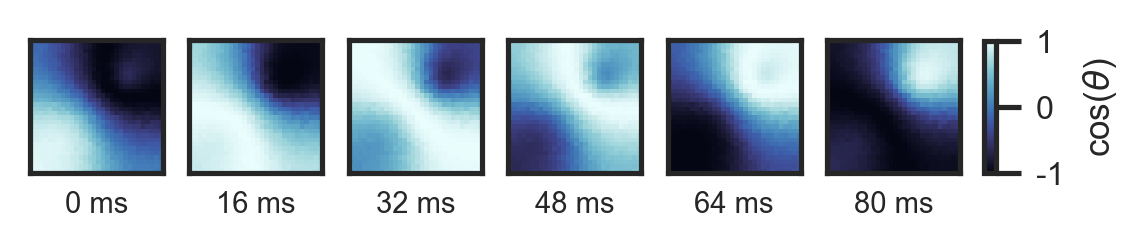

In [45]:
# wave example plots
number_of_images = 6
time_start = 9260  # ms
time_end = 9340  # ms
samples = (np.linspace(time_start, time_end, number_of_images)/integration_step_size).astype(int)
xlabels = [f"{s - np.min(samples)} ms" for s in samples] 

plot_imshow_timeseries(activity, samples, xlabels, '', r'cos($\theta$)',
                       vmin=-1,
                       vmax=1,
                       cbticks=[-1, 0, 1], 
                       cbticklabels=['-1', '0', '1'],
                       cmap=cmap_waves,
                       figsize=(4,0.8),
                       position=[0.92, 0.22, 0.01, 0.55],
                       xlabel_fontsize=7
                      )

#plt.savefig(os.path.join(data_path, '03_results/03_example_wave_intrinsic-freq-gradient.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(data_path, '03_results/03_example_wave_intrinsic-freq-gradient.svg'), dpi=300, transparent=False, bbox_inches='tight')